# Exploratory Data Analysis of Stimulus Triggered Averages
*Ian Malone*

### Load data and check structure

In [137]:
import pandas as pd



#path = 'D:\\Data\\df_STA_%s_2020_12_14.csv' % project
path = 'D:\\Data\\df_STA_%s_2021_01_07.csv' % project

df_sta = pd.read_csv(path)
df_sta.head()

,Animal,Day_Postop,Day_Stim,Side,Stim_Amplitude,Sample,STA_Amplitude
0,N01,999,1,Left,10.0,0,0.019782
1,N01,999,1,Left,10.0,1,0.015173
2,N01,999,1,Left,10.0,2,0.020359
3,N01,999,1,Left,10.0,3,0.019855
4,N01,999,1,Left,10.0,4,0.018697


#### For this analysis, we will only keep the right side EMG for SPARC and left side EMG for Neilsen (for now)

In [138]:
if 'NEIL' in path: 
    df_sta = df_sta[df_sta["Side"] == 'Left']
else:
    df_sta = df_sta[df_sta["Side"] == 'Right']

In [139]:
print(df_sta.Animal.unique())
print(df_sta.Day_Postop.unique())
print(df_sta.Day_Stim.unique())
print(df_sta.Side.unique())
print(df_sta.Stim_Amplitude.unique())

['N01' 'N04' 'N05' 'N09' 'N10' 'N11' 'N13' 'N14' 'N15' 'N16' 'N17' 'N19'
 'N20' 'N21' 'N22' 'N23' 'N24' 'N25' 'N26' 'N27' 'N28' 'N29' 'N30' 'N31'
 'N32' 'N33']
[999   2   3   4   5   6   1]
[1 2 3 4 0]
['Left']
[ 10.  20.  30.  40.  50.  60.  70.  80.  90. 100. 110. 120. 130. 140.
 150. 160. 170. 180. 190. 200. 210. 220. 230. 240. 250. 260. 270. 280.
 290. 300. 310. 320. 330. 340. 350. 360. 370. 380. 390. 400. 410. 420.
 430. 440. 450. 490. 460. 470. 480. 500. 510. 520. 530. 540. 550. 560.
 570. 580. 590. 600. 610. 620. 630. 640. 650. 660. 670. 680. 690. 700.
 710. 720. 730. 740. 750. 760. 770. 780. 790. 800. 810. 820. 830. 840.
 850. 860. 870. 880. 890. 900. 910.  15.  25.  35.  45.  55.  65.  75.
  85.  95. 105. 115. 125. 135. 145. 155. 165. 175. 185. 195. 205. 215.
 225. 235. 245. 255. 265. 275. 285. 295. 305. 315. 325. 335. 345. 355.
 365. 375. 385. 395. 405. 415. 425. 435. 445. 455. 575. 735. 685.]


In [140]:
#df_sta.groupby(['Animal'])['Day_Stim'].unique()

### Plot stimulus triggered average waveforms
##### For each current amplitude, each animal, and each day
There is a lot of data here, so we will subset. We also need to remove the stimulus artifact.

In [141]:
sampling_frequency = 5000 # hertz
df_sta['Time'] = df_sta['Sample']/sampling_frequency # create time column based on samples and sampling frequency
df_sta['Time'] = df_sta['Time']*1000
df_sta.head()

,Animal,Day_Postop,Day_Stim,Side,Stim_Amplitude,Sample,STA_Amplitude,Time
0,N01,999,1,Left,10.0,0,0.019782,0.0
1,N01,999,1,Left,10.0,1,0.015173,0.2
2,N01,999,1,Left,10.0,2,0.020359,0.4
3,N01,999,1,Left,10.0,3,0.019855,0.6
4,N01,999,1,Left,10.0,4,0.018697,0.8


###### The plot below is the raw STA data before any processing

In [142]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# sns.set(font_scale=1)
# plt.figure(figsize=(20,12))

# ## you will need to subset df_sta to only plot certain stimulus amplitudes

# g = sns.FacetGrid(df_sta_sub, col='Day_Stim', row='Animal', hue='Stim_Amplitude')
# g.map_dataframe(sns.lineplot, x='Time', y='STA_Amplitude')
# g.set_axis_labels('Time (ms)', 'Ampltiude (V)')
# g.add_legend()
# #plt.savefig('C:\\Users\\Ian\\Downloads\\saving-a-seaborn-plot-as-pdf-file.pdf')


In [143]:
# remove the stimulus artifact
df_sta_noart = df_sta.copy()
df_sta_noart = df_sta_noart[df_sta_noart['Sample'] >= 11]

###### The plot below shows the normalized STAs with stimulus artifact removed

In [144]:
# ## you will need to subset df_sta to only plot certain stimulus amplitudes

# g = sns.FacetGrid(df_sta_sub_noart, col='Day_Stim', row='Animal', hue='Stim_Amplitude')
# g.map_dataframe(sns.lineplot, x='Time', y='STA_Amplitude')
# g.set_axis_labels('Time (ms)', 'Ampltiude (V)')
# g.add_legend()
# # plt.savefig('C:\\Users\\Ian\\Downloads\\STA_plots_norm_no_artifact.pdf')

### Calculate area under the stimulus triggered average curves 
##### For each current amplitude, each animal, and each day

In [145]:
#### KEEP THIS. MAY SPLIT INTO TIME BINS IN FUTURE

# bins = [0.001, 0.004, 0.007, 0.010, 0.013, 0.0298] # define bins
# labels = ['1 to 4 ms', '4 to 7 ms', '7 to 10 ms', '10 to 13 ms', '13 to 29.8 ms'] # define bin labels
# #labels = [1, 2, 3, 4, 5]

# df_bin = df_sta_sub_norm.copy()
# df_bin['Time_Bin'] = pd.cut(df_bin['Time'], bins, labels=labels, right=False) # add Time_Bin column to dataframe
# df_bin = df_bin.reindex(columns=['Animal', 'Day', 'Side', 'Stim_Amplitude', 'Sample', 'Time', 'Time_Bin', 'STA_Scaled'])
# df_bin.rename(columns = {'Time_Bin':'Bin'}, inplace = True) 
# df_bin = df_bin[df_bin['Bin'] != '13 to 29.8 ms'] # drop all data 13 ms after the stimulation
# df_bin.head()


# from scipy import integrate

# df_auc = df_bin.groupby(['Animal', 'Day', 'Side', 'Stim_Amplitude', 'Bin'])['STA_Scaled'].apply(integrate.simps).reset_index()
# df_auc.rename(columns = {'STA_Scaled':'STA_AUC'}, inplace = True)
# df_auc = df_auc.dropna()
# df_auc.head()

In [146]:
df_noisefloor_auc = df_sta_noart.copy()
df_noisefloor_auc = df_noisefloor_auc[(df_noisefloor_auc['Time'] > 20.0)]
df_noisefloor_auc.head()

,Animal,Day_Postop,Day_Stim,Side,Stim_Amplitude,Sample,STA_Amplitude,Time
101,N01,999,1,Left,10.0,101,0.026517,20.2
102,N01,999,1,Left,10.0,102,0.020794,20.4
103,N01,999,1,Left,10.0,103,0.022700,20.6
104,N01,999,1,Left,10.0,104,0.028331,20.8
105,N01,999,1,Left,10.0,105,0.031767,21.0


In [147]:
df_auc = df_sta_noart.copy()
df_auc = df_auc[(df_auc['Time'] > 2.0) & (df_auc['Time'] < 10.2)]
df_auc.tail()

,Animal,Day_Postop,Day_Stim,Side,Stim_Amplitude,Sample,STA_Amplitude,Time
1694846,N33,6,4,Left,600.0,46,0.190707,9.2
1694847,N33,6,4,Left,600.0,47,0.152887,9.4
1694848,N33,6,4,Left,600.0,48,0.123473,9.6
1694849,N33,6,4,Left,600.0,49,0.102801,9.8
1694850,N33,6,4,Left,600.0,50,0.103474,10.0


In [148]:
import numpy as np
# define animal groups
injstim = ['N09','N10','N11','N13','N27','N28','N29','N30']
noinjstim = ['N01','N04','N05','N31','N32','N33','N34','N35'] 
injnostim = ['N14','N15','N16','N21','N22','N23','N36','N37']
noinjnostim = ['N17','N19','N20','N24','N25','N26','N38','N39'] 

# add animal group information to the dataframe
conditions = [
    (df_auc['Animal'].isin(injstim) ),
    (df_auc['Animal'].isin(noinjstim) ),
    (df_auc['Animal'].isin(injnostim) ),
    (df_auc['Animal'].isin(noinjnostim) )]
choices = ['Injury and Stimulation', 'No Injury and Stimulation', 'Injury and No Stimulation', 'No Injury and No Stimulation']
df_auc['Group'] = np.select(conditions, choices)
df_auc.head()

,Animal,Day_Postop,Day_Stim,Side,Stim_Amplitude,Sample,STA_Amplitude,Time,Group
11,N01,999,1,Left,10.0,11,0.026453,2.2,No Injury and Stimulation
12,N01,999,1,Left,10.0,12,0.027991,2.4,No Injury and Stimulation
13,N01,999,1,Left,10.0,13,0.027984,2.6,No Injury and Stimulation
14,N01,999,1,Left,10.0,14,0.026587,2.8,No Injury and Stimulation
15,N01,999,1,Left,10.0,15,0.027326,3.0,No Injury and Stimulation


In [149]:
df_noisefloor_peak = df_noisefloor_auc.copy()
df_noisefloor_peak = df_noisefloor_peak.groupby(['Animal', 'Day_Postop', 'Day_Stim', 'Side', 'Stim_Amplitude'])['STA_Amplitude'].agg('mean').reset_index()
df_noisefloor_peak = df_noisefloor_peak.rename(columns={"STA_Amplitude": "STA_Noise_Floor"})
df_noisefloor_peak.head()

,Animal,Day_Postop,Day_Stim,Side,Stim_Amplitude,STA_Noise_Floor
0,N01,999,1,Left,10.0,0.027038
1,N01,999,1,Left,20.0,0.022429
2,N01,999,1,Left,30.0,0.021366
3,N01,999,1,Left,40.0,0.019737
4,N01,999,1,Left,50.0,0.031949


In [150]:
df_noisefloor_auc = df_noisefloor_auc.groupby(['Animal', 'Day_Postop', 'Day_Stim', 'Side', 'Stim_Amplitude'])['STA_Amplitude'].agg('mean').reset_index()
df_noisefloor_auc['STA_Amplitude'] = df_noisefloor_auc['STA_Amplitude'] * 7.8 # 7.8 because the length of the STA is 7.8 ms
df_noisefloor_auc = df_noisefloor_auc.rename(columns={"STA_Amplitude": "STA_Noise_Floor"})
df_noisefloor_auc.head()

,Animal,Day_Postop,Day_Stim,Side,Stim_Amplitude,STA_Noise_Floor
0,N01,999,1,Left,10.0,0.210894
1,N01,999,1,Left,20.0,0.174942
2,N01,999,1,Left,30.0,0.166652
3,N01,999,1,Left,40.0,0.153945
4,N01,999,1,Left,50.0,0.249201


In [151]:
df_peak = df_auc.copy()
df_peak = df_peak.groupby(['Animal', 'Day_Postop', 'Day_Stim', 'Side', 'Stim_Amplitude', 'Group'])['STA_Amplitude'].agg('max').reset_index()
df_peak.rename(columns = {'STA_Amplitude':'STA_Peak'}, inplace = True)
df_peak = df_peak.drop(columns=['Day_Postop', 'Side'])
df_peak.head()

,Animal,Day_Stim,Stim_Amplitude,Group,STA_Peak
0,N01,1,10.0,No Injury and Stimulation,0.042865
1,N01,1,20.0,No Injury and Stimulation,0.042906
2,N01,1,30.0,No Injury and Stimulation,0.036920
3,N01,1,40.0,No Injury and Stimulation,0.063588
4,N01,1,50.0,No Injury and Stimulation,0.073174


We now need to integrate the stimulus triggered average curves to find the area beneath them. We can then compare these areas under the curve (AUCs) between groups, days, stimulus intensities, etc.

The trapezoidal rule provides a simple way to integrate a function but typically has much larger error than Simpson's rule without saving significant compute time. We will use Simpson's rule.

In [152]:
from scipy import integrate

df_auc = df_auc.groupby(['Animal', 'Day_Postop', 'Day_Stim', 'Side', 'Stim_Amplitude', 'Group'])['STA_Amplitude'].apply(integrate.simps).reset_index()
df_auc.rename(columns = {'STA_Amplitude':'STA_AUC'}, inplace = True)
df_auc = df_auc.drop(columns=['Day_Postop', 'Side'])
df_auc.head()

,Animal,Day_Stim,Stim_Amplitude,Group,STA_AUC
0,N01,1,10.0,No Injury and Stimulation,1.040341
1,N01,1,20.0,No Injury and Stimulation,1.053330
2,N01,1,30.0,No Injury and Stimulation,1.025544
3,N01,1,40.0,No Injury and Stimulation,1.375108
4,N01,1,50.0,No Injury and Stimulation,1.515141


In [153]:
# df_peak.to_csv('D:\\df_peak_raw.csv', index=False) 
# df_auc.to_csv('D:\\df_auc_raw.csv', index=False) 

In [154]:
# one hot encoding for injury condition and stimulation condition

choices = ['Injury and Stimulation', 'No Injury and Stimulation', 'Injury and No Stimulation', 'No Injury and No Stimulation']

def injury(row):
    if (row['Group'] == 'Injury and Stimulation') | (row['Group'] == 'Injury and No Stimulation'):
        val = 1
    elif (row['Group'] == 'No Injury and Stimulation') | (row['Group'] == 'No Injury and No Stimulation'):
        val = 0
    else:
        val = -1
    return val

def stimulation(row):
    if (row['Group'] == 'Injury and Stimulation') | (row['Group'] == 'No Injury and Stimulation'):
        val = 1
    elif (row['Group'] == 'Injury and No Stimulation') | (row['Group'] == 'No Injury and No Stimulation'):
        val = 0
    else:
        val = -1
    return val

In [155]:
# percent change from noise floor to peak for each day

df_peak_change = df_peak.copy()
df_peak_change["STA_Noise_Floor"] = df_noisefloor_peak["STA_Noise_Floor"]
df_peak_change['STA_Percent_Noise_Floor'] = ((df_peak_change['STA_Peak'].sub(df_peak_change["STA_Noise_Floor"])).div(df_peak_change["STA_Noise_Floor"])).mul(100)
df_peak_change.head()

,Animal,Day_Stim,Stim_Amplitude,Group,STA_Peak,STA_Noise_Floor,STA_Percent_Noise_Floor
0,N01,1,10.0,No Injury and Stimulation,0.042865,0.027038,58.538890
1,N01,1,20.0,No Injury and Stimulation,0.042906,0.022429,91.302731
2,N01,1,30.0,No Injury and Stimulation,0.036920,0.021366,72.800185
3,N01,1,40.0,No Injury and Stimulation,0.063588,0.019737,222.182643
4,N01,1,50.0,No Injury and Stimulation,0.073174,0.031949,129.034625


In [156]:
df_peak_change['Injury'] = df_peak_change.apply(injury, axis=1)
df_peak_change['Stimulation'] = df_peak_change.apply(stimulation, axis=1)
df_peak_change = df_peak_change.drop(columns=['STA_Peak', 'STA_Noise_Floor'])
df_peak_change.rename(columns = {'STA_Percent_Noise_Floor':'Peak_Percent_Noise_Floor'}, inplace = True) 
df_peak_change.head()


,Animal,Day_Stim,Stim_Amplitude,Group,Peak_Percent_Noise_Floor,Injury,Stimulation
0,N01,1,10.0,No Injury and Stimulation,58.538890,0,1
1,N01,1,20.0,No Injury and Stimulation,91.302731,0,1
2,N01,1,30.0,No Injury and Stimulation,72.800185,0,1
3,N01,1,40.0,No Injury and Stimulation,222.182643,0,1
4,N01,1,50.0,No Injury and Stimulation,129.034625,0,1


In [157]:
df_mean_day_peak_change = df_peak_change.copy()
df_mean_day_peak_change = df_mean_day_peak_change.groupby(['Day_Stim', 'Stim_Amplitude', 'Group'])['Peak_Percent_Noise_Floor'].agg('mean').reset_index()
df_mean_day_peak_change = df_mean_day_peak_change.rename(columns={'Peak_Percent_Noise_Floor':'Mean_Peak_Percent_Noise_Floor'})
df_mean_day_peak_change.head()

,Day_Stim,Stim_Amplitude,Group,Mean_Peak_Percent_Noise_Floor
0,0,100.0,Injury and Stimulation,82.649056
1,0,100.0,No Injury and Stimulation,98.146122
2,0,110.0,Injury and Stimulation,76.879589
3,0,110.0,No Injury and Stimulation,82.874806
4,0,120.0,Injury and Stimulation,51.435834


<Figure size 1440x1440 with 0 Axes>

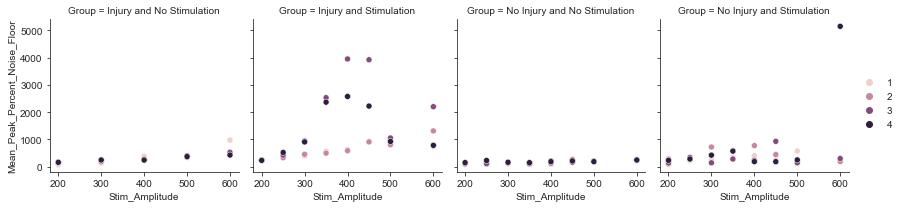

In [158]:
stim_amp_list = [200, 250, 300, 350, 400, 450, 500, 600]
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
# sns.set(font_scale=2)
sns.set_style("ticks")
g = sns.FacetGrid(df_mean_day_peak_change[(df_mean_day_peak_change['Stim_Amplitude'].isin(stim_amp_list)) & (df_mean_day_peak_change['Day_Stim']>0)], col="Group")
g = (g.map(sns.scatterplot, "Stim_Amplitude", "Mean_Peak_Percent_Noise_Floor", 'Day_Stim').add_legend())


In [159]:
# percent change from noise floor to auc for each day

df_day_auc_change = df_auc.copy()
df_day_auc_change["STA_Noise_Floor"] = df_noisefloor_auc["STA_Noise_Floor"]
df_day_auc_change['STA_Percent_Noise_Floor'] = ((df_day_auc_change['STA_AUC'].sub(df_day_auc_change["STA_Noise_Floor"])).div(df_day_auc_change["STA_Noise_Floor"])).mul(100)
df_day_auc_change.head()

,Animal,Day_Stim,Stim_Amplitude,Group,STA_AUC,STA_Noise_Floor,STA_Percent_Noise_Floor
0,N01,1,10.0,No Injury and Stimulation,1.040341,0.210894,393.301469
1,N01,1,20.0,No Injury and Stimulation,1.053330,0.174942,502.100974
2,N01,1,30.0,No Injury and Stimulation,1.025544,0.166652,515.380948
3,N01,1,40.0,No Injury and Stimulation,1.375108,0.153945,793.246078
4,N01,1,50.0,No Injury and Stimulation,1.515141,0.249201,508.000257


In [160]:
df_day_auc_change['Injury'] = df_day_auc_change.apply(injury, axis=1)
df_day_auc_change['Stimulation'] = df_day_auc_change.apply(stimulation, axis=1)
#df_day_pchange = df_day_pchange.drop(columns=['Day_Postop', 'Side', 'STA_AUC', 'STA_Noise_Floor'])
#df_day_pchange.to_csv('D:\\df_abstract.csv', index=False) 
# df_day_pchange.head(50)
df_day_auc_change = df_day_auc_change.drop(columns=['STA_AUC', 'STA_Noise_Floor'])
df_day_auc_change.rename(columns = {'STA_Percent_Noise_Floor':'AUC_Percent_Noise_Floor'}, inplace = True) 

df_day_auc_change.head()

,Animal,Day_Stim,Stim_Amplitude,Group,AUC_Percent_Noise_Floor,Injury,Stimulation
0,N01,1,10.0,No Injury and Stimulation,393.301469,0,1
1,N01,1,20.0,No Injury and Stimulation,502.100974,0,1
2,N01,1,30.0,No Injury and Stimulation,515.380948,0,1
3,N01,1,40.0,No Injury and Stimulation,793.246078,0,1
4,N01,1,50.0,No Injury and Stimulation,508.000257,0,1


In [168]:
df_cluster = df_day_auc_change.copy()
df_cluster = df_cluster.drop(columns=['Group',])
df_cluster['AnimalID'] = [int(x.strip()[-2:]) for x in df_cluster['Animal']]
df_cluster = df_cluster.drop(columns=['Animal'])
df_cluster = df_cluster[(df_cluster['Day_Stim'] == 3) | (df_cluster['Day_Stim'] == 4)]
df_cluster = df_cluster[(df_cluster['Stim_Amplitude'] > 299) & (df_cluster['Stim_Amplitude'] < 510)]
df_cluster = df_cluster.groupby(['AnimalID', 'Injury', 'Stimulation', ])['STA_Amplitude'].agg('mean').reset_index()

df_cluster.head()

,Day_Stim,Stim_Amplitude,AUC_Percent_Noise_Floor,Injury,Stimulation,AnimalID
93,3,330.0,1879.947584,0,1,1
94,3,370.0,3181.247018,0,1,1
95,3,410.0,4468.789539,0,1,1
96,3,450.0,6760.451231,0,1,1
97,3,490.0,6784.635969,0,1,1


In [74]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', 
                                     linkage='complete').fit(df_day_auc_change)
labels=clustering.labels_

In [76]:
# Number of clusters
clustering.n_clusters_



4263

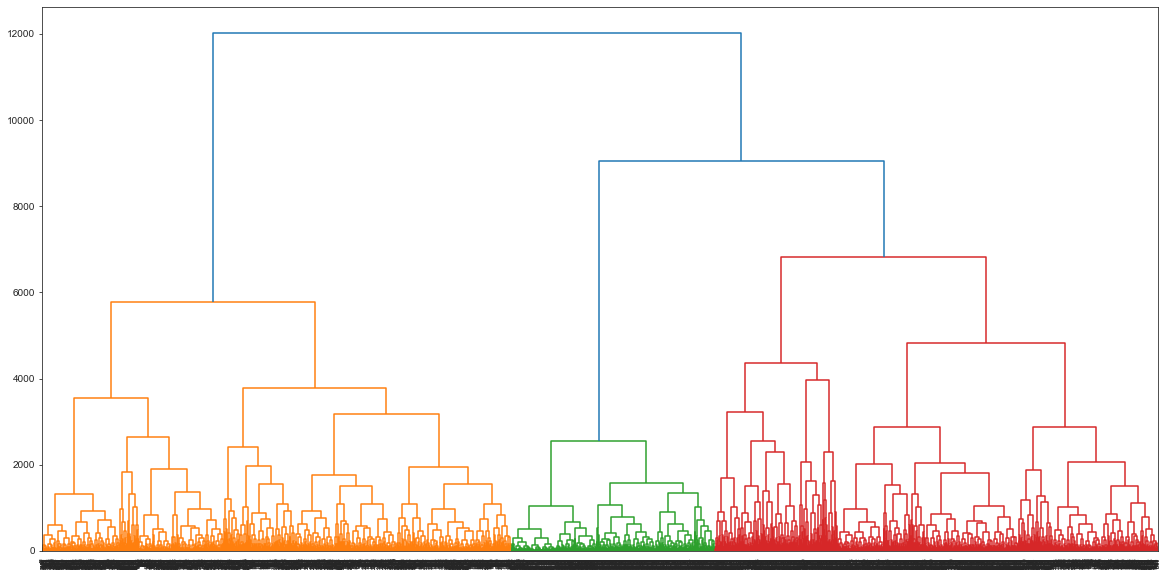

In [78]:
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster import hierarchy

Z = hierarchy.linkage(clustering.children_, 'complete')


plt.figure(figsize=(20,10))
dn = hierarchy.dendrogram(Z)

In [79]:
df_day_auc_change.head()

,Day_Stim,Stim_Amplitude,AUC_Percent_Noise_Floor,Injury,Stimulation,AnimalID
0,1,10.0,393.301469,0,1,1
1,1,20.0,502.100974,0,1,1
2,1,30.0,515.380948,0,1,1
3,1,40.0,793.246078,0,1,1
4,1,50.0,508.000257,0,1,1


In [ ]:
df_cluster = df_day_auc_change[df_day_auc_change['Stim_Amplitude']]

In [73]:
df_timeseries = df_auc.copy()
df_timeseries['Injury'] = df_timeseries.apply(injury, axis=1)
df_timeseries['Stimulation'] = df_timeseries.apply(stimulation, axis=1)
df_timeseries.head()

,Animal,Day_Stim,Stim_Amplitude,Group,STA_AUC,Injury,Stimulation
0,N01,1,10.0,No Injury and Stimulation,1.040341,0,1
1,N01,1,20.0,No Injury and Stimulation,1.053330,0,1
2,N01,1,30.0,No Injury and Stimulation,1.025544,0,1
3,N01,1,40.0,No Injury and Stimulation,1.375108,0,1
4,N01,1,50.0,No Injury and Stimulation,1.515141,0,1


In [67]:


# from scipy.cluster.hierarchy import dendrogram

# def plot_dendrogram(model, **kwargs):
#     # Create linkage matrix and then plot the dendrogram

#     # create the counts of samples under each node
#     counts = np.zeros(model.children_.shape[0])
#     n_samples = len(model.labels_)
#     for i, merge in enumerate(model.children_):
#         current_count = 0
#         for child_idx in merge:
#             if child_idx < n_samples:
#                 current_count += 1  # leaf node
#             else:
#                 current_count += counts[child_idx - n_samples]
#         counts[i] = current_count

#     linkage_matrix = np.column_stack([model.children_, model.distances_,
#                                       counts]).astype(float)

#     # Plot the corresponding dendrogram
#     dendrogram(linkage_matrix, **kwargs)
    
# plt.title('Hierarchical Clustering Dendrogram')
# # plot the top three levels of the dendrogram
# plot_dendrogram(clustering, truncate_mode='level', p=3)
# plt.xlabel("Number of points in node (or index of point if no parenthesis).")
# plt.show()

Error in callback <function flush_figures at 0x00000142937783A0> (for post_execute):


KeyboardInterrupt: 

In [ ]:
# # these are dataframes that erica requested for abstract

# df_peak_400 = df_peak_change.copy()
# df_peak_day4 = df_peak_change.copy()
# df_auc_400 = df_day_pchange.copy()
# df_auc_day4 = df_day_pchange.copy()

# df_peak_400 = df_peak_400[df_peak_400['Stim_Amplitude'] == 400]
# df_peak_day4 = df_peak_day4[df_peak_day4['Day_Stim'] == 4]
# df_auc_400 = df_auc_400[df_auc_400['Stim_Amplitude'] == 400]
# df_auc_day4 = df_auc_day4[df_auc_day4['Day_Stim'] == 4]

# df_peak_400.to_csv('D:\\df_peak_400.csv', index=False) 
# df_peak_day4.to_csv('D:\\df_peak_day4.csv', index=False) 
# df_auc_400.to_csv('D:\\df_auc_400.csv', index=False) 
# df_auc_day4.to_csv('D:\\df_auc_day4.csv', index=False) 

# df_peak_400_day4 = df_peak_400.copy()
# df_peak_400_day4 = df_peak_400_day4[df_peak_400_day4['Day_Stim'] == 4]

# df_auc_400_day4 = df_auc_400.copy()
# df_auc_400_day4 = df_auc_400_day4[df_auc_400_day4['Day_Stim'] == 4]

# df_peak_400_day4.to_csv('D:\\df_peak_400_day4.csv', index=False) 
# df_auc_400_day4.to_csv('D:\\df_auc_400_day4.csv', index=False) 

# df_auc = df_day_pchange.copy()
# df_peak = df_peak_change.copy()
# df_auc.to_csv('D:\\df_auc.csv', index=False) 
# df_peak.to_csv('D:\\df_peak.csv', index=False) 

# CODE BELOW THIS NEEDS TO BE INTEGRATED TO CODE ABOVE

In [ ]:
# import numpy as np

#### for SPARC project
# # add animal group information to the dataframe
# conditions = [
#     (df_auc['Animal'] == 'S01') | (df_auc['Animal'] == 'S02'),
#     (df_auc['Animal'] == 'S03') | (df_auc['Animal'] == 'S04'),
#     (df_auc['Animal'] == 'S05') | (df_auc['Animal'] == 'S06')]
# choices = ['Group A', 'Group B', 'Group C']
# df_auc['Group'] = np.select(conditions, choices)
# df_auc.head()

In [ ]:
# # function to calculate percent change
# def perc_change_from_d4(df, day):
#     return ((df[str(day)].sub(df['4'])).div(df['4'])).mul(100)

In [ ]:
# ### changed function above to take df arg

# df_auc_pchange = df_auc.pivot_table(index=['Animal', 'Side', 'Stim_Amplitude', 'Bin', 'Group'], 
#                     columns='Day', 
#                     values='STA_AUC').reset_index()

# for n in np.arange(6,20,2):
#     df_auc_pchange["Day 4 to Day %s" % n] = perc_change_from_d4(n)

# df_auc_pchange = df_auc_pchange.drop(df_auc_pchange.columns[5:13], axis=1)
# df_auc_pchange.head()

In [ ]:
# df_auc_pchange = pd.melt(df_auc_pchange, id_vars=['Animal', 'Side', 'Stim_Amplitude', 'Bin', 'Group'], var_name='Days', value_name='Percent_Change')
# df_auc_pchange.head()

In [ ]:
# df_auc_pchange[(df_auc_pchange['Group'] == 'Group C') & (df_auc_pchange['Days'] == 'Day 4 to Day 16') & (df_auc_pchange['Animal'] == 'S05')].head(50)

In [ ]:
# # all the bar plots
# sns.set(font_scale=1.5)
# g = sns.FacetGrid(df_auc_pchange, col="Days", row='Bin')
# g.map(sns.barplot, "Group", "Percent_Change", 'Stim_Amplitude')

In [ ]:
# day_range = 'Day 4 to Day 18'

# plt.figure(figsize=(20,12))
# sns.set(font_scale=2)
# sns.set_style("ticks")
# ax = sns.boxplot(x='Group', y='Percent_Change', hue='Stim_Amplitude', data=df_auc_pchange[df_auc_pchange['Days'] == day_range])
# ax.legend(loc="upper left", title='Stimulation Amplitude (uA)', title_fontsize="small")
# ax.set_title(project + ': Percent Change AUC ' + day_range)
# ax.set_ylabel('Percent Change STA AUC')

### Other analyses

- Peak to peak from stimulus triggered average for each current amplitude, each animal, each day
- Latency from stimulus pulse to stimulus triggered average for each current amplitude, each animal, each day
- Time domains of stimulus triggered average
- Differences in any of these parameters based on time of day?
- How are we going to present the impedance data in the Neilsen paper? I’m still not clear on this.
- Additional things we can look at (e.g., wavelet, FFT, HMM, etc.)
- Look in manuscript file for notes on ideas. Also look in Daily Notes on OneNote for papers that did EMG analysis well.
- Add information on time of day and stimulus amplitude from Neurochip